In [ ]:
from highway_config import *
from dqn import *
from dqn_v2 import *
import pprint

print(env.spec)
pprint.pprint(env.config)

In [ ]:
action_space = env.action_space
observation_space = env.observation_space

print(f"Action space: {action_space}")
print(f"Observation space: {observation_space}")

plt.imshow(env.render())
plt.show()

The observation space corresponds to the information available to the agent at each step. It then chooses an action based on this information. In our case (Kinematics observations), this info is a grid of vehicles_count * n_features where each value corresponds to a feature of a particular vehicule (not including the ego-vehicule ?). This space is stored in a Box object defined by (lower bound, upper bound, (vehicles_count, n_features), numerical_type). Since this observation space is in 2D, we had to flatten this matrix before feeding it into the DQN.

The action space is an integer that results from the available actions (longitudinal and/or lateral) and the quantization step (fixed by the parameter actions_per_axis). In the end there are actions_per_axis actions if only one of longiutdinal or lateral is True and actions_per_axis ** 2 if both are true.

## Utility functions

In [ ]:
def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, 0)
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'Episode length {rewards}')

## Training a DQN on highway-env

### Setup of the DQN agent and training loop

In [ ]:
gamma = 0.8
batch_size = 32
buffer_capacity = 15_000
update_target_every = 32

epsilon_start = 0.8
decrease_epsilon_factor = 100
epsilon_min = 0.02

# hidden_size = 256
input_channels = 7

learning_rate = 5e-4

arguments = (env,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_min,
            learning_rate,
            input_channels
        )

print(arguments)

agent = DQN_v2(*arguments)

def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    training_rewards = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done: 
            # print(f"State shape: {state.shape}")
            action = agent.get_action(state)
            # print(f"Action: {action}")

            next_state, reward, terminated, truncated, _ = env.step(action)
            loss_val = agent.update(state, action, reward, terminated, next_state)

            state = next_state
            losses.append(loss_val)

            done = terminated or truncated
            total_time += 1

        if ((ep+1)% eval_every == 0):
            rewards = eval_agent(agent, env, n_sim=5)
            print("episode =", ep+1, ", reward = ", np.mean(rewards))
            training_rewards.append(np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                break
                
    return losses, training_rewards

## Imports and setup

### Show initial state of environment

### Run the training loop and evaluate agent

episode = 10 , reward =  0.8
episode = 20 , reward =  0.0
episode = 30 , reward =  14.320924922660765
episode = 40 , reward =  6.116317664431915
episode = 50 , reward =  0.6
episode = 60 , reward =  0.26666666666666666
episode = 70 , reward =  1.4
episode = 80 , reward =  0.8
episode = 90 , reward =  3.2294608087402983
episode = 100 , reward =  0.0
episode = 110 , reward =  0.4
episode = 120 , reward =  8.739128897067896
episode = 130 , reward =  2.560351398034553
episode = 140 , reward =  4.533333333333333
episode = 150 , reward =  11.650062307594485
episode = 160 , reward =  0.8
episode = 170 , reward =  0.6
episode = 180 , reward =  24.290065731154748
episode = 190 , reward =  0.8
episode = 200 , reward =  5.629182143891284
episode = 210 , reward =  2.294119048661303
episode = 220 , reward =  0.8
episode = 230 , reward =  5.9919949352183774
episode = 240 , reward =  3.011354573797591
episode = 250 , reward =  4.131790672562942
episode = 260 , reward =  3.050012976857262
episode = 27

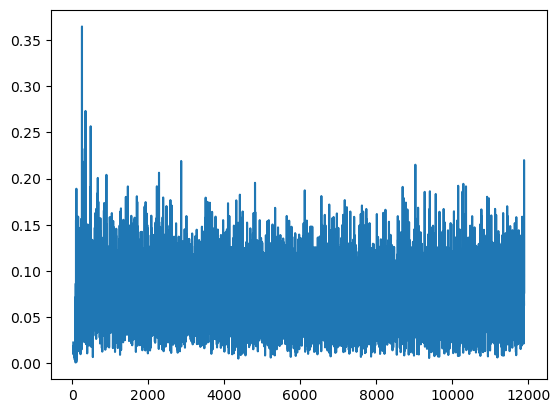

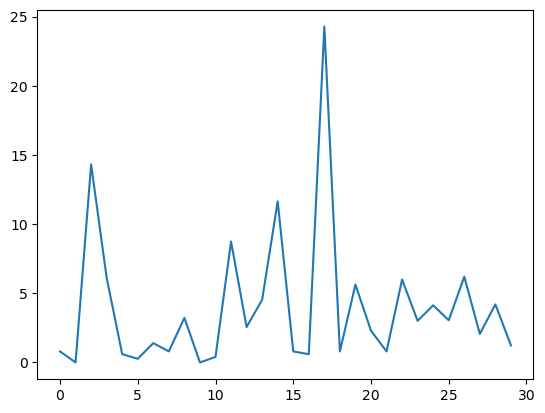

Model saved to trained_highway_agent_vCNN.pth

rewards after training =  [1.         1.         1.         3.17641976 0.         1.
 1.         0.         1.         1.         1.         1.
 1.         1.         0.         1.         1.         1.
 1.         1.        ]
mean reward after training =  0.9588209879334221


In [ ]:
# Run the training loop and save the state of the agent
N_episodes = 300
losses, training_rewards = train(env, agent, N_episodes)
plt.plot(losses)
plt.show()
plt.plot(training_rewards)
plt.show()
agent.save_state("trained_highway_agent_vCNN.pth")

# Or load the state
# agent.load_state("trained_highway_agent.pth")

# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("rewards after training = ", rewards)
print("mean reward after training = ", np.mean(rewards))

## Vizualisations

### Show trained agent over one episode

In [ ]:
# os.environ["SDL_VIDEODRIVER"] = "dummy"
# from IPython.display import clear_output

# run_one_episode(env, agent, display=True)

### Save video of trained agent

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output
import gymnasium as gym
import numpy as np
from copy import deepcopy

def run_one_episode_and_save(env, agent, to_display=True, save_video=True, plot_info=True, max_steps=100):
    display_env = deepcopy(env)  # Create a deep copy of the environment for isolated manipulation
    state, _ = display_env.reset()
    frames = []  # Store frames for animation
    rewards = 0
    step = 0
    state_history = []

    done = False
    while not done:
        clear_output(wait=True)
        # Render the frame and store for video creation
        frame = display_env.render()
        frames.append(frame)
        if to_display:
            plt.imshow(frame)
            plt.axis('off')  # Hide axes for clean display
            plt.show()

        # Execute the agent's policy
        action = agent.get_action(state, 0)  # Assuming get_action accepts state and epsilon, adjust if different
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        step += 1
        if plot_info:
            state_history.append(state)
        if step > max_steps:
            done = True
        

    if to_display:
        print(f'Episode length: {rewards}')

    # If requested to save the video, proceed with saving
    if save_video:
        fig, ax = plt.subplots()
        img_ax = ax.imshow(frames[0])  # Show the first frame
        ax.axis('off')  # Hide axes

        def update(frame):
            img_ax.set_data(frame)  # Update the image displayed

        ani = FuncAnimation(fig, update, frames=frames, repeat=False)

        # Save the animation as MP4
        video_filename = 'trained_agent_simulation_vCNN.mp4'
        ani.save(video_filename, writer='ffmpeg', fps=10)

        # Optionally display the animation within the notebook
        plt.close(fig)  # Close the figure to prevent it from displaying now
        if to_display:
            video_tag = f'<video src="{video_filename}" width="100%" controls loop autoplay>'
            display(HTML(video_tag))

    if to_display:
        display_env.close()  # Properly close the environment when done

    if plot_info:
        # Plot the heatmap of the state values on average over time 
        state_history = np.array(state_history)
        mean_state_history = np.sum(state_history, axis=0) / state_history.shape[0]
        presence = mean_state_history[:, :, 0]
        # speed = mean_state_history[:, :, 1]
        # lane = mean_state_history[:, :, 2]
        plt.figure(figsize=(15, 5))
        plt.imshow(presence, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title('Heatmap of presence')
        plt.show()


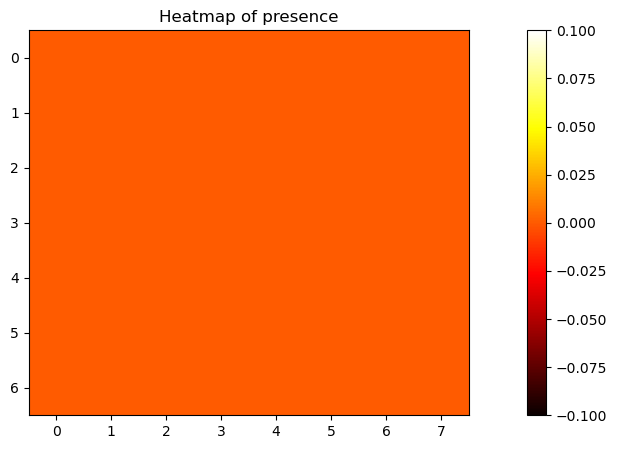

In [ ]:
# simulate the trained agent and save the video
run_one_episode_and_save(env, agent, to_display=True, save_video=True, plot_info=True, max_steps=100)